# MARS SPECTROMETRY 2: GAS CHROMATOGRAPHY - BENCHMARK

_Did Mars ever have environmental conditions that could have supported life?_ This is one of the key questions in the field of planetary science. NASA missions like the Curiosity and Perseverance rovers have a rich array of capabilities that can help answer this question, one of which is collecting rock and soil samples and taking measurements that can be used to determine their chemical makeup. These samples can be analyzed for chemical signatures that indicate the environment's habitability, or potentially even signs of microbial life directly.

The aim of this work is to build a model to automatically analyze mass spectrometry data for geological samples of scientific interest in understanding the present and past habitability of Mars. Specifically, the model should detect the presence of certain families of chemical compounds in data collected from performing gas chromatography–mass spectrometry (GCMS) on a set of geological material samples.

[Reference](https://drivendata.co/blog/mars-spectrometry-gcms-benchmark)

### LIBRARIES

In [1]:
import random
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import msgc

In [2]:
RANDOM_SEED = 42
tqdm.pandas()

### DATA

In [3]:
metadata = pd.read_csv("data/metadata.csv")

## EXPLORATORY DATA ANALYSIS

### MASS SPECTRUM

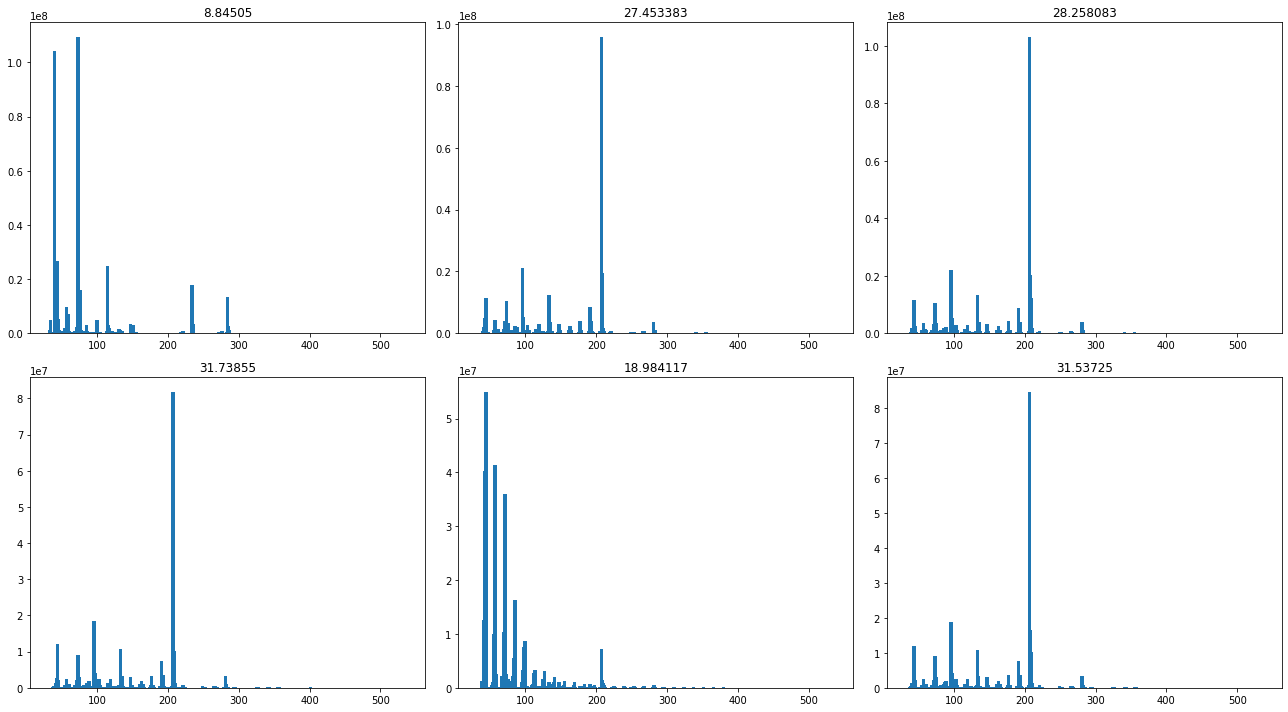

In [4]:
sample = pd.read_csv("data/train_features/S0002.csv") # Test sample.
msgc.viz.grid_plot(sample, msgc.viz.plot_mass_spectrum, random.sample(list(sample.time.unique()), 6), cols=3) # Plot

### SPECTOGRAMS

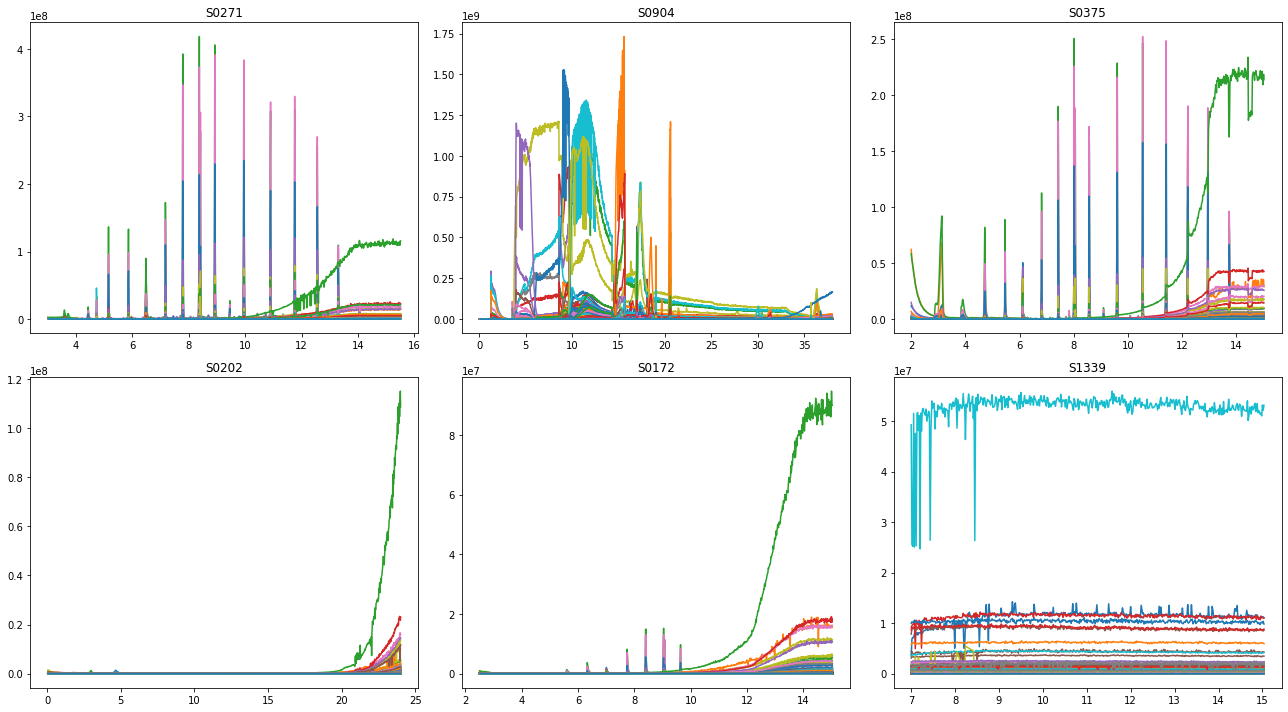

In [5]:
msgc.viz.grid_plot(metadata, msgc.viz.plot_spectrogram, random.sample(list(metadata.sample_id.values), 6), cols=3)

- There is a diversity in the time range of experiments (some are as short as 7 minutes, while others extend to nearly 40), and the intensity ranges differ as well.
- There are different m/z ion types that peak at different times. (Each colored line represents a distinct m/z value).
- For some samples, there are other ion types that are consistently present at low abundance levels. These are likely background abundances that are irrelevant. (In general, a spectrogram is useful for the peaks in abundances it shows at different times).

### MISC

Derivatized

In [6]:
metadata.derivatized.value_counts(dropna=False)
# NaN doesn't mean not, it simply means unknown.

NaN    1023
1.0     561
Name: derivatized, dtype: int64

Train labels

In [7]:
train_labels = pd.read_csv("data/train_labels.csv", index_col="sample_id")
target_cols = train_labels.columns
train_labels.columns

Index(['aromatic', 'hydrocarbon', 'carboxylic_acid',
       'nitrogen_bearing_compound', 'chlorine_bearing_compound',
       'sulfur_bearing_compound', 'alcohol', 'other_oxygen_bearing_compound',
       'mineral'],
      dtype='object')

1. aromatic: sample contains aromatic compounds
1. hydrocarbon: sample contains hydrocarbon compounds
1. carboxylic_acid: sample contains carboxylic acid compounds, such as amino acids
1. nitrogen_bearing_compound: sample contains nitrogen-containing compounds, such as amines or nitriles
1. chlorine_bearing_compound: sample contains chlorine
1. sulfur_bearing_compound: sample contains sulfur
1. alcohol: sample contains alcohol compounds
1. other_oxygen_bearing_compound: sample contains compounds that contain oxygen but are not carboxylic acids or alcohols, such as esters and ethers
1. mineral: sample contains mineral compounds

In [8]:
train_labels.aggregate("sum", axis=1).value_counts(normalize=True)

1    0.473424
0    0.374536
2    0.071693
3    0.046972
4    0.016069
8    0.013597
5    0.003708
dtype: float64

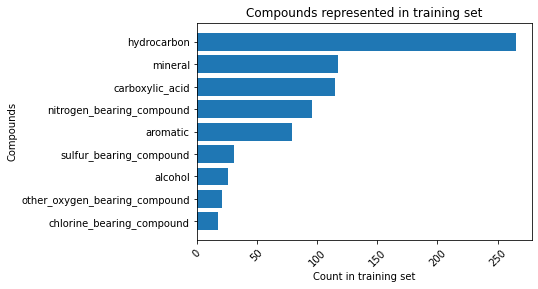

In [9]:
sumlabs = train_labels.aggregate("sum").sort_values()

plt = msgc.viz.plt
plt.barh(sumlabs.index, sumlabs, align="center")
plt.ylabel("Compounds")
plt.xticks(rotation=45)
plt.xlabel("Count in training set")
plt.title("Compounds represented in training set");

- A large share (about 37 percent) of our samples do not have a positive label for any of the classes, and
- For some classes, such as chlorine-bearing compounds, other oxygen-bearing compounds, alcohols, and sulfur-bearing compounds, we have very few samples (less than 50).

## PREPROCESSING

In [10]:
# Train sample.
sample_paths_ls = metadata[metadata["split"] == "train"].features_path
training_stats = pd.DataFrame(sample_paths_ls)
training_stats.columns = ["fpath"]

In [11]:
# (
#     training_stats["time_min"],
#     training_stats["time_max"],
#     training_stats["time_range"],
#     training_stats["mass_min"],
#     training_stats["mass_max"],
#     training_stats["mass_range"],
# ) = zip(*training_stats['fpath'].progress_apply(msgc.features.get_time_mass_stats))

In [12]:
# training_stats.describe()

### 1. Standardizing which m/z values to include

In [13]:
sample_ = msgc.features.drop_frac_and_He(sample)

In [14]:
sample

,time,mass,intensity
0,7.002083,33.209106,903181.0
1,7.002083,33.961044,3876882.0
2,7.002083,35.105576,32380.0
3,7.002083,35.925064,257204.0
4,7.002083,37.095093,100347.0
...,...,...,...
804327,37.009117,531.692749,499.0
804328,37.009117,532.336426,966.0
804329,37.009117,533.372070,2613.0
804330,37.009117,534.300049,3565.0


### 2. Removing background ion presences

In [15]:
# pass

### 3. Convert abundances to relative abundances

Name: scikit-learn
Version: 1.1.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: c:\users\moses\anaconda3\envs\transformers\lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 
